In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import svm
from sklearn import preprocessing
import traj_classification as tc
from sklearn.decomposition import PCA
import h5py
import time

### Load data

In [2]:
traj_train = np.load('traj_train.npy')
labels_train = np.load('labels_train.npy')
print 'train traj and labels loaded'

traj_test = np.load('traj_test.npy')
labels_test = np.load('labels_test.npy')
print 'test traj and labels loaded'

IOError: [Errno 2] No such file or directory: 'traj_train.npy'

### Params

In [7]:
slotSize = 0
clf_SVM = None

### Helper functions

In [66]:
def __formatIntoFeatureVectorsAndLabels(traj, labels):
    """
    Helper function. Converts the traj and labels into a feature vector matrix (design matrix) and a labels array, which is the proper format to input into the SVM.
    :param traj: the demodded trajectories in an np array, with 3 indices: iqIndex, trajIndex, timeIndex
    :param labels: the labels corresponding to the trajectories, 1d np array
    :return: inputVectors (each feature vector is the I vector concatted with the Q vector) and labels_ggexc (labels for each trajectory, 0 for gg, 1 for exc)
    """
    numTotalTraj = traj.shape[1]
    numTimeBins = traj.shape[2]  # 5000 #num time bins per traj
    
    print '@@@ Start slotting; time: ', time.time() - timeStart
    #: get inputVectors and labels_ggexc
    ###
    numSlots = numTimeBins / slotSize  # num slots per traj
    
#     #: obsolete code bcause it's too slow
#     traj_slotted = np.zeros((2, numTotalTraj, numSlots))  # indices: iqIndex, labelIndex, trajIndex, slotIndex
#     for trajIndex in np.arange(numTotalTraj):
#         for j in np.arange(numSlots): #j is slotIndex
#             traj_slotted[:, trajIndex, j] = traj[:, trajIndex, j*slotSize:j*slotSize+slotSize].mean(1)
#             traj_slotted[1, trajIndex, j] = traj[1, trajIndex, j*slotSize:j*slotSize+slotSize].mean()
    
    traj_slotted = np.reshape(traj, (2, numTotalTraj, numSlots, slotSize)).mean(3)
    
    print '@@@ Finished slotting; time: ', time.time() - timeStart
    
#     print '@@@ Start concatting; time: ', time.time() - timeStart
    inputVectors = np.concatenate((traj_slotted[0, :, :], traj_slotted[1, :, :]), axis=1) #sample vectors to input into the SVM;
    labels_ggexc = np.array([0 if labels[i]==0 else 1 for i in np.arange(numTotalTraj) ]) # this groups gg as label 0, and exc as label 1
#     print '@@@ Finished concatting; time: ', time.time() - timeStart
    
    return inputVectors, labels_ggexc

In [9]:
def __findFidelity(inputVectors, labels_ggexc):
    """
    Helper function. Calculates the fidelity
    :param inputVectors:
    :param labels_ggexc:
    :return: fidelity
    """
    numTraj = inputVectors.shape[0]

    #: find train fidelity
    ###
    labels_ggexc_predicted = clf_SVM.predict(inputVectors)

    num_gg_exc = 0  # num of samples that are predicted 'gg' but are actually exc
    num_exc_gg = 0  # num of samples that are predicted 'exc' but are actually gg
    num_exc = 0  # total num of true exc sample
    num_gg = 0  # total num of true exc sample

    for i in np.arange(numTraj):
        if labels_ggexc[i] == 1:
            num_exc = num_exc + 1
            if labels_ggexc_predicted[i] == 0:
                num_gg_exc = num_gg_exc + 1
        else:
            num_gg = num_gg + 1
            if labels_ggexc_predicted[i] == 1:
                num_exc_gg = num_exc_gg + 1

    prob_gg_exc = 1.0 * num_gg_exc / num_exc
    prob_exc_gg = 1.0 * num_exc_gg / num_gg

    fid_ggexc = 1 - (prob_gg_exc + prob_exc_gg) / 2

    return fid_ggexc

### Fit the SVM

In [25]:
print type(traj.shape[2] / slotSize)
print traj.shape[2] / slotSize



<type 'int'>
100


In [67]:
### Testing _formatInto..


timeStart = time.time()
print '@@@ Start timing'
"""
Fits the SVM.

:param traj:
:param labels:
:param slotSize: size (number of time units) of each slot, for performing slot weights integration
:param tuneC: True if you want the method to tune C
:param lstC: None if you want to use the default list of C's to sweep through for finding the optimal C; should be an np array or a list.
:param validationFraction: fraction of the traj's to use as the validation set (tuning C happens on the validation set)
:return: self
"""
traj = traj_train
labels = labels_train
slotSize=50 
tuneC=False
lstC=None
validationFraction=0.25




numTotalTraj = traj.shape[1]

print '@@@ Start formatIntoFeatureVectorsAndLabels; time: ', time.time() - timeStart
inputVectors, labels_ggexc = __formatIntoFeatureVectorsAndLabels(traj, labels)
print '@@@ Finished formatIntoFeatureVectorsAndLabels; time: ', time.time() - timeStart

@@@ Start timing
@@@ Start formatIntoFeatureVectorsAndLabels; time:  0.000982999801636
@@@ Start slotting; time:  0.00145316123962
@@@ Finished slotting; time:  1.67877006531
@@@ Finished formatIntoFeatureVectorsAndLabels; time:  1.71913719177


In [48]:
### testing

test = np.random.rand(2,1000,10000)

%timeit test.reshape(2, 100, 50, -1).mean(2)


100 loops, best of 3: 19.7 ms per loop


In [62]:
### testing

A = np.array([[[1,2,3,0,0,0],[1,2,4,1,4,3],[1,2,5,1,2,3],[1,2,6,1,2,3],[1,2,7,1,2,3]], \
              [[1,3,3,0,0,0],[2,3,4,1,2,3],[2,3,5,1,2,3],[2,3,6,1,2,3],[2,3,7,1,2,3]]])
print A.shape
A_reshaped = A.reshape((2,5,2,3))
print A_reshaped.shape
print A_reshaped.sum(3)

# want: A_reshape = A.reshape((2, numTotalTraj, numTimeBins/slotSize, slotSize))

(2, 5, 6)
(2, 5, 2, 3)
[[[ 6  0]
  [ 7  8]
  [ 8  6]
  [ 9  6]
  [10  6]]

 [[ 7  0]
  [ 9  6]
  [10  6]
  [11  6]
  [12  6]]]


@@@ Start timing
@@@ Start formatIntoFeatureVectorsAndLabels; time:  0.00180101394653
@@@ Start slotting; time:  0.00328087806702
@@@ Finished slotting; time:  0.263383865356
@@@ Finished formatIntoFeatureVectorsAndLabels; time:  0.313799858093
Tuning C...
On C = 1e-15 ; fid = 0.5
On C = 1.88739182214e-15 ; fid = 0.5
On C = 3.56224789026e-15 ; fid = 0.5
On C = 6.7233575365e-15 ; fid = 0.5
On C = 1.26896100317e-14 ; fid = 0.5
On C = 2.39502661999e-14 ; fid = 0.5
On C = 4.52035365636e-14 ; fid = 0.5
On C = 8.53167852417e-14 ; fid = 0.5
On C = 1.61026202756e-13 ; fid = 0.5
On C = 3.03919538231e-13 ; fid = 0.5
On C = 5.73615251045e-13 ; fid = 0.5
On C = 1.08263673387e-12 ; fid = 0.502063584973
On C = 2.04335971786e-12 ; fid = 0.520066428185
On C = 3.85662042116e-12 ; fid = 0.589471415136
On C = 7.27895384398e-12 ; fid = 0.721450603006
On C = 1.37382379588e-11 ; fid = 0.827172607772
On C = 2.5929437974e-11 ; fid = 0.87787222687
On C = 4.89390091848e-11 ; fid = 0.897342612892
On C = 9.236708

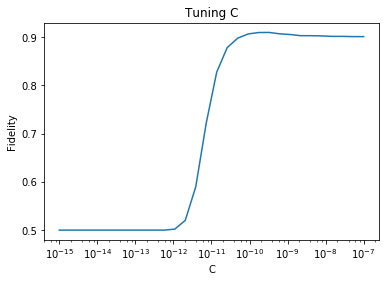

In [68]:
### 

timeStart = time.time()
print '@@@ Start timing'
"""
Fits the SVM.

:param traj:
:param labels:
:param slotSize: size (number of time units) of each slot, for performing slot weights integration
:param tuneC: True if you want the method to tune C
:param lstC: None if you want to use the default list of C's to sweep through for finding the optimal C; should be an np array or a list.
:param validationFraction: fraction of the traj's to use as the validation set (tuning C happens on the validation set)
:return: self
"""
traj = traj_train
labels = labels_train
slotSize=50 
tuneC=True
lstC=None
validationFraction=0.25




numTotalTraj = traj.shape[1]

print '@@@ Start formatIntoFeatureVectorsAndLabels; time: ', time.time() - timeStart
inputVectors, labels_ggexc = __formatIntoFeatureVectorsAndLabels(traj, labels)
print '@@@ Finished formatIntoFeatureVectorsAndLabels; time: ', time.time() - timeStart

#: fit the clf_SVM, tune C if chosen to
###
inputVectors_shuffled, labels_ggexc_shuffled = shuffle(inputVectors, labels_ggexc, random_state=0)

if tuneC == False:
    clf_SVM = svm.LinearSVC(C=1.0)
    clf_SVM.fit(inputVectors_shuffled, labels_ggexc_shuffled)
else:
    print 'Tuning C...'
    lstFid = []
    startIndex_validation = int(numTotalTraj * (1 - validationFraction))
    if lstC is None:
        lstC = 10 ** np.linspace(-15, -7, 30)
    for C in lstC:
        clf_SVM = svm.LinearSVC(C=C)
        clf_SVM.fit(inputVectors_shuffled[0:startIndex_validation], labels_ggexc_shuffled[0:startIndex_validation])
        temp_fid = __findFidelity(inputVectors_shuffled[startIndex_validation: ], labels_ggexc_shuffled[startIndex_validation: ])
        print 'On C =', C, '; fid =', temp_fid
        lstFid = lstFid + [temp_fid]

    plt.figure()
    plt.plot(lstC, lstFid)
    plt.gca().set_xscale('log')
    plt.title('Tuning C')
    plt.xlabel('C')
    plt.ylabel('Fidelity')

    optimalC = lstC[np.argmax(lstFid)]
    print 'Chose optimal C = ', optimalC
    
    print '@@@ Start fitting the SVM; time: ', time.time() - timeStart
    clf_SVM = svm.LinearSVC(C=optimalC)
    clf_SVM.fit(inputVectors_shuffled, labels_ggexc_shuffled)
    print '@@@ Finished fitting the SVM; time: ', time.time() - timeStart
    
    
# #: Tune slotSize

# lstFid_tuneSlotSize = []
# startIndex_validation = int(numTotalTraj * (1 - validationFraction))
# lstSlotSize = np.array([5, 10, 20, 50, 100, 200, 500])
# for s in lstSlotSize:
#     slotSize = s
#     print '@@@ !Start formatIntoFeatureVectorsAndLabels; time: ', time.time() - timeStart
#     inputVectors, labels_ggexc = __formatIntoFeatureVectorsAndLabels(traj, labels)
#     print '@@@ !Finished formatIntoFeatureVectorsAndLabels; time: ', time.time() - timeStart
#     inputVectors_shuffled, labels_ggexc_shuffled = shuffle(inputVectors, labels_ggexc, random_state=0)
#     clf_SVM = svm.LinearSVC(C=1.0)
#     clf_SVM.fit(inputVectors_shuffled, labels_ggexc_shuffled)
#     temp_fid = __findFidelity(inputVectors_shuffled[startIndex_validation: ], labels_ggexc_shuffled[startIndex_validation: ])
#     print 'On slotSize =', slotSize, '; fid =', temp_fid
#     lstFid_tuneSlotSize = lstFid_tuneSlotSize + [temp_fid]

# plt.figure()
# plt.plot(lstSlotSize, lstFid_tuneSlotSize)
# plt.gca().set_xscale('log')
# plt.title('Tuning slotSize')
# plt.xlabel('slotSize')
# plt.ylabel('Fidelity')

    
    
    
    
    
    
# print '@@@ Start finding train fidelity; time: ', time.time() - timeStart
# fid_ggexc = __findFidelity(inputVectors_shuffled, labels_ggexc_shuffled)
# print '@@@ Finished finding train fidelity; time: ', time.time() - timeStart

# print 'train fid_ggexc: ', fid_ggexc

### Score (test fidelity)

In [70]:
timeStart = time.time()

traj = traj_test
labels= labels_test

print '@@@ Start formatIntoFeatureVectorsAndLabels; time: ', time.time() - timeStart
inputVectors, labels_ggexc = __formatIntoFeatureVectorsAndLabels(traj, labels)
print '@@@ Finished formatIntoFeatureVectorsAndLabels; time: ', time.time() - timeStart

fid_ggexc = __findFidelity(inputVectors, labels_ggexc)

print 'test fid: ', fid_ggexc

@@@ Start formatIntoFeatureVectorsAndLabels; time:  0.00570201873779
@@@ Start slotting; time:  0.012708902359
@@@ Finished slotting; time:  0.480344057083
@@@ Finished formatIntoFeatureVectorsAndLabels; time:  0.492660999298
test fid:  0.906666666667


<type 'float'>


## Scratch work


In [7]:
### testing


A = np.array([[[1,2,3,0,0,0],[1,2,4,1,4,3],[1,2,5,1,2,3],[1,2,6,1,2,3],[1,2,7,1,2,3]], \
              [[1,3,3,0,0,0],[2,3,4,1,2,3],[2,3,5,1,2,3],[2,3,6,1,2,3],[2,3,7,1,2,3]]])
B = np.array([[[5,5,5,0,0,0],[5,5,5,1,4,3],[5,5,5,1,2,3],[1,2,6,1,2,3],[1,2,7,1,2,3]], \
              [[5,5,5,0,0,0],[5,5,5,1,2,3],[5,5,5,1,2,3],[2,3,6,1,2,3],[2,3,7,1,2,3]]])

C = np.concatenate((A,B), axis=1)
print A
print 'C'
print C

# want: A_reshape = A.reshape((2, numTotalTraj, numTimeBins/slotSize, slotSize))

[[[1 2 3 0 0 0]
  [1 2 4 1 4 3]
  [1 2 5 1 2 3]
  [1 2 6 1 2 3]
  [1 2 7 1 2 3]]

 [[1 3 3 0 0 0]
  [2 3 4 1 2 3]
  [2 3 5 1 2 3]
  [2 3 6 1 2 3]
  [2 3 7 1 2 3]]]
C
[[[1 2 3 0 0 0]
  [1 2 4 1 4 3]
  [1 2 5 1 2 3]
  [1 2 6 1 2 3]
  [1 2 7 1 2 3]
  [5 5 5 0 0 0]
  [5 5 5 1 4 3]
  [5 5 5 1 2 3]
  [1 2 6 1 2 3]
  [1 2 7 1 2 3]]

 [[1 3 3 0 0 0]
  [2 3 4 1 2 3]
  [2 3 5 1 2 3]
  [2 3 6 1 2 3]
  [2 3 7 1 2 3]
  [5 5 5 0 0 0]
  [5 5 5 1 2 3]
  [5 5 5 1 2 3]
  [2 3 6 1 2 3]
  [2 3 7 1 2 3]]]


In [9]:
D = np.zeros((2,0,6))
E = np.concatenate((D,A), axis=1)
print E


[[[ 1.  2.  3.  0.  0.  0.]
  [ 1.  2.  4.  1.  4.  3.]
  [ 1.  2.  5.  1.  2.  3.]
  [ 1.  2.  6.  1.  2.  3.]
  [ 1.  2.  7.  1.  2.  3.]]

 [[ 1.  3.  3.  0.  0.  0.]
  [ 2.  3.  4.  1.  2.  3.]
  [ 2.  3.  5.  1.  2.  3.]
  [ 2.  3.  6.  1.  2.  3.]
  [ 2.  3.  7.  1.  2.  3.]]]


## Plotting traj

In [4]:
rawdata = np.zeros((2,0,4,7000))
filenames_large = ['//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190223_Trajectories_0_/190223_Trajectories_0_.hdf5', '//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190235_Trajectories_1_/190235_Trajectories_1_.hdf5', '//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190248_Trajectories_2_/190248_Trajectories_2_.hdf5', '//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190300_Trajectories_3_/190300_Trajectories_3_.hdf5', '//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190312_Trajectories_4_/190312_Trajectories_4_.hdf5']
filenames_small = ['//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190223_Trajectories_0_/190223_Trajectories_0_.hdf5', '//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190235_Trajectories_1_/190235_Trajectories_1_.hdf5']

for filename in filenames_large:
    f = h5py.File(filename,'r')
    rawdata = np.concatenate((rawdata, f['data']['Dependent0'][()]), axis=1) #this turns the h5data into a numpy file

    print filename
    print 'Shape of raw data: ', rawdata.shape
    f.close()

traj_train, labels_train = tc.demod(rawdata[:,:8000,:,:]) #@@@ change the index depending on wheter using big or small dataset
traj_test, labels_test = tc.demod(rawdata[:,10000:20000,:,:])
print 'train and test data demodded'

//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190223_Trajectories_0_/190223_Trajectories_0_.hdf5
Shape of raw data:  (2L, 5000L, 4L, 7000L)
//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190235_Trajectories_1_/190235_Trajectories_1_.hdf5
Shape of raw data:  (2L, 10000L, 4L, 7000L)
//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190248_Trajectories_2_/190248_Trajectories_2_.hdf5
Shape of raw data:  (2L, 15000L, 4L, 7000L)
//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190300_Trajectories_3_/190300_Trajectories_3_.hdf5
Shape of raw data:  (2L, 20000L, 4L, 7000L)
//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170308/190312_Trajectories_4_/190312_Trajectories_4_.hdf5
Shape of raw data:  (2L, 25000L, 4L, 7000L)
train and test data demodded


In [26]:
def __formatIntoFeatureVectorsAndLabels(traj, labels):
    """
    Helper function. Converts the traj and labels into a feature vector matrix (design matrix) and a labels array, which is the proper format to input into the SVM.
    :param traj: the demodded trajectories in an np array, with 3 indices: iqIndex, trajIndex, timeIndex
    :param labels: the labels corresponding to the trajectories, 1d np array
    :return: scaled (i.e. mean removal and scaled variance to 1) inputVectors (each feature vector is the I vector concatted with the Q vector); and labels_ggexc (labels for each trajectory, 0 for gg, 1 for exc)
    """
    slotSize = 50
    
    numTotalTraj = traj.shape[1]
    numTimeBins = traj.shape[2]  # 5000 #num time bins per traj

    #: get inputVectors and labels_ggexc
    ###
    numSlots = numTimeBins / slotSize  # num slots per traj
    
    traj_slotted = np.reshape(traj, (2, numTotalTraj, numSlots, slotSize)).mean(3)

    inputVectors = np.concatenate((traj_slotted[0, :, :], traj_slotted[1, :, :]), axis=1) #sample vectors to input into the SVM;
    labels_ggexc = np.array([0 if labels[i]==0 else 1 for i in np.arange(numTotalTraj) ]) # this groups gg as label 0, and exc as label 1

    inputVectors = preprocessing.scale(inputVectors)

#     if self.usePCA:
#         if fitNewPCA:
#             self.pca = PCA(n_components=20, whiten=True)
#             self.pca.fit(inputVectors)
#             print 'PCA explained variance ratio: ', self.pca.explained_variance_ratio_

#         inputVectors = self.pca.transform(inputVectors)

    return inputVectors, labels_ggexc

(2L, 32000L, 7000L)
(32000L, 280L)


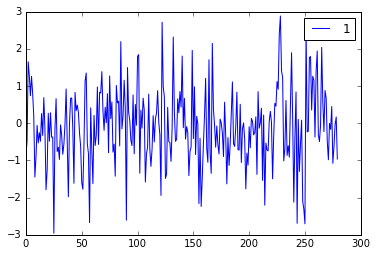

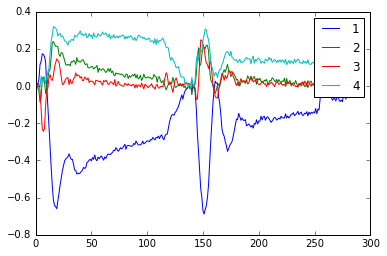

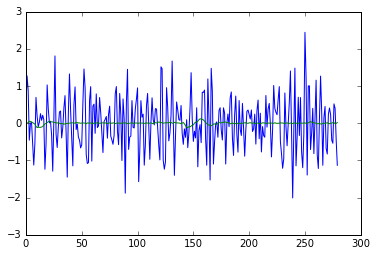

In [28]:
print traj_train.shape

inputVectors, labels_ggexc = __formatIntoFeatureVectorsAndLabels(traj_train, labels_train)

print inputVectors.shape


plt.plot(inputVectors[0, :])
# plt.plot(inputVectors[8000, :])
# plt.plot(inputVectors[16000, :])
# plt.plot(inputVectors[24000, :])
plt.legend([1,2,3,4])

plt.figure()
plt.plot(inputVectors[0:8000, :].mean(0))
plt.plot(inputVectors[8000:16000, :].mean(0))
plt.plot(inputVectors[16000:24000, :].mean(0))
plt.plot(inputVectors[24000:32000, :].mean(0))
plt.legend([1,2,3,4])

plt.figure()
plt.plot(np.gradient(inputVectors[0, :]))
plt.plot(np.gradient(inputVectors[0:8000, :], axis=1).mean(0))

In [12]:
A = np.array([[[1,2,3,0,0,0],[1,2,4,1,4,3],[1,2,5,1,2,3],[1,2,6,1,2,3],[1,2,7,1,2,3]], \
              [[1,3,3,0,0,0],[2,3,4,1,2,3],[2,3,5,1,2,3],[2,3,6,1,2,3],[2,3,7,1,2,3]]])
B = np.array([[[5,5,5,0,0,0],[5,5,5,1,4,3],[5,5,5,1,2,3],[1,2,6,1,2,3],[1,2,7,1,2,3]], \
              [[5,5,5,0,0,0],[5,5,5,1,2,3],[5,5,5,1,2,3],[2,3,6,1,2,3],[2,3,7,1,2,3]]])

In [15]:
print A
print 'now gradient:'
print np.gradient(A, axis=2)

[[[1 2 3 0 0 0]
  [1 2 4 1 4 3]
  [1 2 5 1 2 3]
  [1 2 6 1 2 3]
  [1 2 7 1 2 3]]

 [[1 3 3 0 0 0]
  [2 3 4 1 2 3]
  [2 3 5 1 2 3]
  [2 3 6 1 2 3]
  [2 3 7 1 2 3]]]
now gradient:
[[[ 1.   1.  -1.  -1.5  0.   0. ]
  [ 1.   1.5 -0.5  0.   1.  -1. ]
  [ 1.   2.  -0.5 -1.5  1.   1. ]
  [ 1.   2.5 -0.5 -2.   1.   1. ]
  [ 1.   3.  -0.5 -2.5  1.   1. ]]

 [[ 2.   1.  -1.5 -1.5  0.   0. ]
  [ 1.   1.  -1.  -1.   1.   1. ]
  [ 1.   1.5 -1.  -1.5  1.   1. ]
  [ 1.   2.  -1.  -2.   1.   1. ]
  [ 1.   2.5 -1.  -2.5  1.   1. ]]]


C:\Anaconda2\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


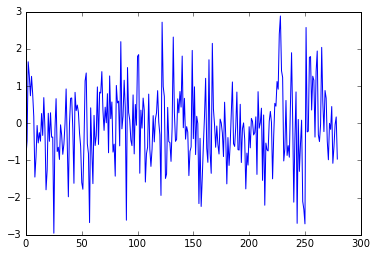

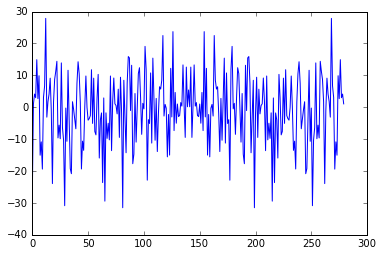

In [16]:
plt.plot(inputVectors[0, :])
plt.figure()
plt.plot(np.fft.fft(inputVectors[0, :]))

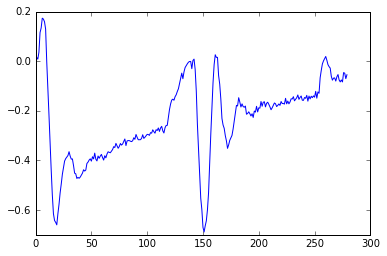

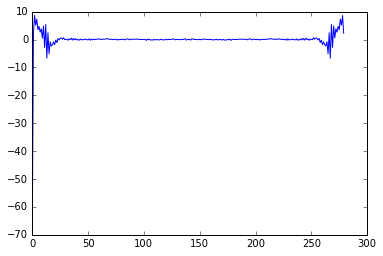

In [18]:
plt.plot(inputVectors[0:8000, :].mean(0))
plt.figure()
plt.plot(np.fft.fft(inputVectors[0:8000, :].mean(0)))

loaded train and test:  ?
Time start:  0.0
Tuning C...
On C = 1e-07 ; validation fid = 0.835524281144
On C = 1.81393069391e-07 ; validation fid = 0.837855671652
On C = 3.29034456231e-07 ; validation fid = 0.840770744513
On C = 5.96845699512e-07 ; validation fid = 0.847104647547
On C = 1.08263673387e-06 ; validation fid = 0.859182093452
On C = 1.96382800193e-06 ; validation fid = 0.87667002644
On C = 3.56224789026e-06 ; validation fid = 0.897829920346
On C = 6.46167078747e-06 ; validation fid = 0.915402786734
On C = 1.17210229753e-05 ; validation fid = 0.928725852934
On C = 2.1261123339e-05 ; validation fid = 0.938883219706
On C = 3.85662042116e-05 ; validation fid = 0.943125507357
On C = 6.99564215671e-05 ; validation fid = 0.944031394055
On C = 0.000126896100317 ; validation fid = 0.942940615485
On C = 0.000230180731302 ; validation fid = 0.941347749056
On C = 0.000417531893656 ; validation fid = 0.937920571621
On C = 0.00075737391759 ; validation fid = 0.935997153583
On C = 0.0013738

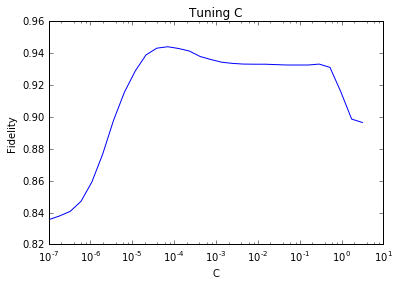

test fid:  0.941633333333
predicted labels for test set [0 0 0 ..., 1 1 1]
Time finish:  252.777999878


In [5]:
traj_train, labels_train = tc.demod(rawdata[:,:8000,:,:]) #@@@ change the index depending on wheter using big or small dataset
traj_test, labels_test = tc.demod(rawdata[:,10000:20000,:,:])
print 'loaded train and test: ', '?'

timeStart = time.time()
print 'Time start: ', time.time() - timeStart

clf = tc.SWInt_SVM()
clf.fit(traj_train, labels_train, typeSVM='linear', tuneC=True, usePCA=False, useDerivativeFeatures=True)
print 'test fid: ', clf.score(traj_test, labels_test)
print 'predicted labels for test set', clf.predict(traj_test)

print 'Time finish: ', time.time() - timeStart

In [12]:
timeStart = time.time()
print 'Time start: ', time.time() - timeStart

print clf.predict(traj_test[:])

print 'Time finish: ', time.time() - timeStart

Time start:  0.0
[0 0 0 ..., 1 1 1]
Time finish:  1.59599995613
